In [ ]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,SnowballStemmer
from nltk.tokenize import TweetTokenizer
import pdb
import numpy as np
import pandas as pd
import nltk
from os import getcwd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load data

In [ ]:
path = "/content/drive/MyDrive/Big_Data/custom_model/"
train_x = np.load(path + 'train_x.npz') 
train_y = np.load(path + 'train_y.npz')
test_x = np.load(path + 'test_x.npz')
test_y = np.load(path + 'test_y.npz')

In [ ]:
train_x = np.array(train_x['arr_0'])
train_y = np.array(train_y['arr_0'])
test_x = np.array(test_x['arr_0'])
test_y = np.array(test_y['arr_0'])

Convert data

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)

x_train = pad_sequences(tokenizer.texts_to_sequences(train_x), maxlen = 250)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_x), maxlen = 250)

encoder = LabelEncoder()
encoder.fit(train_y)

y_train = encoder.transform(train_y)
y_test = encoder.transform(test_y)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

Word embedding

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/MyDrive/Big_Data/custom_model/glove/glove.6B.50d.txt')

#Build Moedel

In [ ]:
def sentences_to_indices(X,word_to_index,max_len):
    m = len(X) #number training_example

    X_indices = np.zeros((m,max_len))
    for i in tqdm(range(m)):
        j = 0
        for w in X[i]:
            if w in word_to_index:
               X_indices[i,j] = word_to_index[w]
               j = j + 1
    return X_indices

def pretrained_embedding_layer(word_to_vec_map,word_to_index): 
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]
    vocab_size = len(word_to_index) + 1

    #Initialize the embedding matrix
    emb_matrix = np.zeros((vocab_size, emb_dim))

    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    embedding_layer = tf.keras.layers.Embedding(vocab_size,emb_dim, input_length=250, trainable = False)
    embedding_layer.build((None,))        

    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

embedding_layer = pretrained_embedding_layer(word_to_vec_map,word_to_index)

model_LSTM = tf.keras.Sequential([
    tf.keras.Input((250,),dtype = 'int32'),
    embedding_layer,
    tf.keras.layers.LSTM(128,return_sequences = True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(128,return_sequences = False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])

model_LSTM.summary()
model_LSTM.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 50)           20000050  
                                                                 
 lstm (LSTM)                 (None, 250, 128)          91648     
                                                                 
 dropout (Dropout)           (None, 250, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 20,223,411
Trainable params: 223,361
Non-t

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Big_Data/custom_model/training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq = 1013 * 2)

model_LSTM.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
history = model_LSTM.fit(
    x_train,
    y_train, 
    epochs = 30,
    validation_split = 0.1,
    verbose = 1,
    shuffle = True,
    callbacks=[cp_callback]
)

Epoch 1/30
1013/1013 [==============================] - 106s 98ms/step - loss: 0.6734 - accuracy: 0.5796 - val_loss: 0.6567 - val_accuracy: 0.6161
Epoch 2/30
1012/1013 [============================>.] - ETA: 0s - loss: 0.6378 - accuracy: 0.6287
Epoch 2: saving model to /content/drive/MyDrive/Big_Data/custom_model/training_2/cp-0002.ckpt
1013/1013 [==============================] - 96s 95ms/step - loss: 0.6377 - accuracy: 0.6288 - val_loss: 0.6070 - val_accuracy: 0.6508
Epoch 3/30
1013/1013 [==============================] - 97s 96ms/step - loss: 0.6707 - accuracy: 0.5564 - val_loss: 0.6902 - val_accuracy: 0.5264
Epoch 4/30
1012/1013 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.5837
Epoch 4: saving model to /content/drive/MyDrive/Big_Data/custom_model/training_2/cp-0004.ckpt
1013/1013 [==============================] - 96s 94ms/step - loss: 0.6636 - accuracy: 0.5838 - val_loss: 0.5884 - val_accuracy: 0.6800
Epoch 5/30
1013/1013 [==============================]

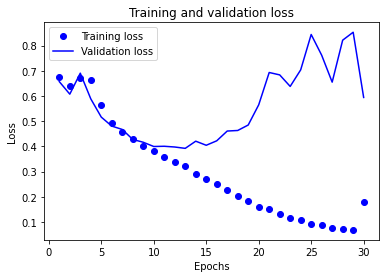

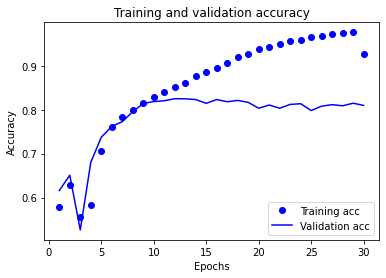

In [ ]:
history_dict = history.history

#visualization
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#training and validataion accuray
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
!cd "/content/drive/MyDrive/Big_Data/custom_model/" 
!mkdir -p saved_model

model_LSTM.save('saved_model/my_model_LSTM')

INFO:tensorflow:Assets written to: saved_model/my_model_LSTM/assets


INFO:tensorflow:Assets written to: saved_model/my_model_LSTM/assets


In [ ]:
model_LSTM.evaluate(x_test,y_test)

282/282 [==============================] - 12s 43ms/step - loss: 0.6009 - accuracy: 0.8060


[0.6008975505828857, 0.8059999942779541]

In [ ]:
def predict(sentence):
    lst = np.array([sentence])
    x = pad_sequences(tokenizer.texts_to_sequences(lst), maxlen = 250)
    a = model_LSTM.predict(x)[0][0]
    
    if a >= 0.5:
       return "positive"
    return "negative"

In [ ]:
sentence = "hey you are terrible and i don't want you"
predict(sentence)

'negative'

In [ ]:
sentence = "happy birthday, you are my everything"
predict(sentence)

'positive'

In [ ]:
sentence = "i'm so happy"
predict(sentence)

'positive'